# Convolutional Neural Network for Image Classification on Cifar-10 Dataset

## Load the Cifar-10 data

In [2]:
import os
import numpy as np
#import cPickle
import _pickle as cPickle
import pandas as pd 
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential 
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras import backend as K

/home/mike/.virtualenvs/mie1516_py3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
PATH = "cifar-10-batches-py/"

In [4]:
class Cifar(object):
    def __init__(self, input_path, dropout_index):
        self.input_path = input_path
        self.dropout_index = dropout_index
        self._get_data()
    
    @staticmethod
    def _unpickle(file):
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo, encoding='latin1')
        return dict
    
    @staticmethod
    def _getfiles(path):
        files = []
        for file in os.listdir(path):
            if "data_batch" in file:
                files.append(file)
        return files
 
    def _get_data(self):

        cifar_9_data = []
        cifar_9_labels = []
        cifar_1_data = []
        cifar_1_labels = []
        
        files = self._getfiles(self.input_path)

        for batch_file in files:
            batch = self._unpickle('{0}/{1}'.format(PATH, batch_file))
            labels = np.array(batch['labels'])
            keep_indexs = np.zeros(len(labels), dtype=bool)
            keep_indexs[labels!=self.dropout_index] = True
            cifar_9_data.append(batch['data'][keep_indexs])
            cifar_9_labels.append(labels[keep_indexs])
            drop_indexs = np.invert(keep_indexs)
            cifar_1_data.append(batch['data'][drop_indexs])
            cifar_1_labels.append(labels[drop_indexs])

        cifar_9_data = np.transpose(np.concatenate(cifar_9_data).reshape(-1,3,32,32), (0, 2, 3, 1))
        cifar_9_labels = np.concatenate(cifar_9_labels)
        cifar_1_data = np.transpose(np.concatenate(cifar_1_data).reshape(-1,3,32,32), (0, 2, 3, 1))
        cifar_1_labels = np.concatenate(cifar_1_labels)
        
        self.data = cifar_9_data.astype('float32')/255
        self.labels = tensorflow.keras.utils.to_categorical(cifar_9_labels, 10)
        
        self.trans_data = cifar_1_data.astype('float32')/255
        self.trans_labels = tensorflow.keras.utils.to_categorical(cifar_1_labels, 10)
        
    def next_data_batch(self, num):
        idx = np.arange(0, len(self.labels))
        np.random.shuffle(idx)
        idx = idx[:num]
        
        return self.data[idx], self.labels[idx]
        
    def next_trans_data_batch(self, num):
        idx = np.arange(0, len(self.trans_labels))
        np.random.shuffle(idx)
        idx = idx[:num]
        batch = self.data[idx]
        
        return self.trans_data[idx], self.trans_labels[idx]

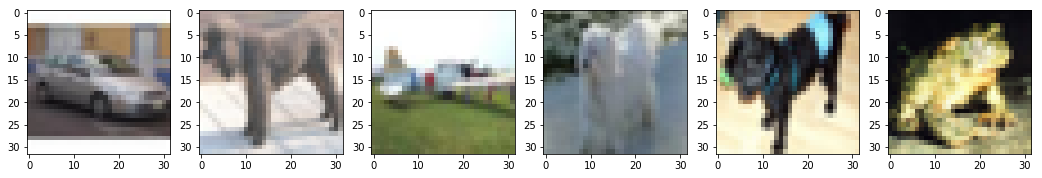

In [5]:
cifar = Cifar(PATH, 9)
data,labels = cifar.next_data_batch(6)
plt.figure(figsize=(18, 10))
reference = data
for i in range(reference.shape[0]):
    plt.subplot(int(reference.shape[0]/6)+1, 6, i+1)
    plt.imshow(reference[i])
    
plt.show()

## Define Keras deep net model and train

In [6]:
batch_size = 128
num_classes = 10
epochs = 50 

In [7]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=cifar.data.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       73856     
__________

In [8]:
# initiate RMSprop optimizer
opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001)
# train the model using RMSprop; reduced data size for less training 
# time since I am on CPU 
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(cifar.data[:20000], cifar.labels[:20000],
                    batch_size=batch_size,
                    validation_data=(cifar.data[20001:30000], cifar.labels[20001:30000]),
                    epochs=epochs,
                    shuffle=True)

Train on 20000 samples, validate on 9999 samples
Epoch 1/50
20000/20000 [==============================]20000/20000 [==============================] - 99s 5ms/step - loss: 2.2768 - acc: 0.1304 - val_loss: 2.2794 - val_acc: 0.1547

Epoch 2/50
20000/20000 [==============================]20000/20000 [==============================] - 100s 5ms/step - loss: 2.1879 - acc: 0.1924 - val_loss: 2.2637 - val_acc: 0.1886

Epoch 3/50
20000/20000 [==============================]20000/20000 [==============================] - 102s 5ms/step - loss: 2.1520 - acc: 0.2041 - val_loss: 2.0907 - val_acc: 0.2262

Epoch 4/50
 7424/20000 [==========>...................] 7424/20000 [==========>...................] - ETA: 58s - loss: 2.1231 - acc: 0.2070

KeyboardInterrupt: 

## Show train and test performance vs. epochs of gradient descent training

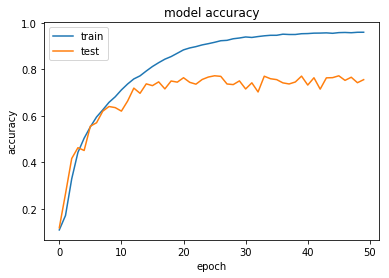

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Show confusion matrix of results

In [9]:
# Label Names(not gaven as metadata)
Label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
    ]

In [10]:
y_pred = np.argmax(model.predict(cifar.data[30000:]), axis=1)   
y_label = np.argmax(cifar.labels[30000:],axis=1)

In [11]:
def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

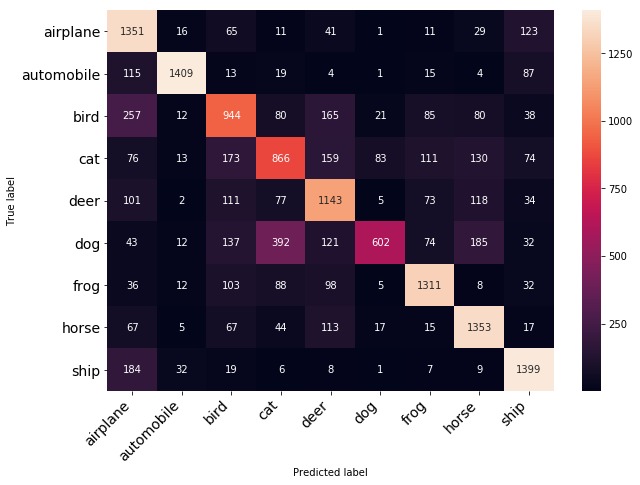

In [12]:
#  Cifar-9 Confusion Matrix
print_confusion_matrix(confusion_matrix(y_label, y_pred), 
                       Label_names[:9])

## Show predicted and actual labels for random images

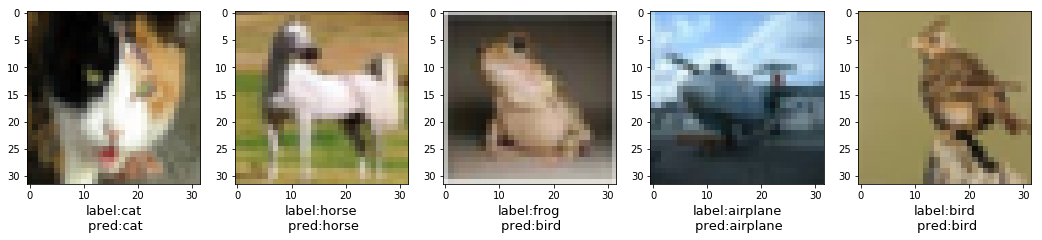

In [13]:
def random_examples(image, label, predict, Label_names, sample_size=5):
    plt.figure(figsize=(18, 10))
    reference = image[:sample_size]
    for i in range(reference.shape[0]):
        plt.subplot(int(reference.shape[0]/sample_size)+1, 
                    sample_size, i+1)
        plt.imshow(reference[i])
        plt.xlabel('label:{0}\n pred:{1}'.format(Label_names[label[i]],
                                                 Label_names[pred[i]]), 
                   fontsize=13)
    plt.show()
image,label = cifar.next_data_batch(5)
label = np.argmax(label, axis=1)
pred = np.argmax(model.predict(image), axis=1)
random_examples(image, label, pred, Label_names)